In [3]:

import pandas as pd
import numpy as np
import re
import collections
import contractions
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import keras
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package wordnet to /Users/kevinha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2023-07-27 08:54:52.416897: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [45]:
df2=pd.read_csv('balanced_dataset_training.csv', encoding='latin')
df_test=pd.read_csv('balanced_dataset_testing.csv', encoding='latin')

In [46]:
df2.head()

,Unnamed: 0,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
0,421,Mobile Engineer,"US, ND, Bismarck",NaN,NaN,<p>We're changing how the world creates and pu...,<p>We are looking for a mobile application eng...,<h3>The Musts:</h3>\r\n<ul>\r\n<li>You think b...,<h3>The Perks (full-time only):</h3>\r\n<ul>\r...,f,t,t,Full-time,Entry level,Unspecified,Program Development,Other,f,t
1,545,BI Consultant & Database Expert,"BE, ,",tech,NaN,<p>hello world</p>\r\n<p>talents23_ drives the...,<p>This fast growing company specialized in da...,<ul>\r\n<li>You know SQL and have professional...,<ul>\r\n<li>WeÃÂ¢ÃÂÃÂre theÃÂÃÂ key An...,f,t,t,Full-time,Associate,NaN,NaN,NaN,f,t
2,806,Customer Service Representative,"US, TX, SAN ANTONIO",NaN,NaN,NaN,<p>SUMMARYResponsible for acting as a liaison ...,<p>Experience: Proficiency with Microsoft Word...,<p>You would be eligible to Benefits after 2mo...,f,f,f,Full-time,Not Applicable,High School or equivalent,Consumer Services,Customer Service,t,t
3,803,Administrative Assistant,"US, CA, Santa Ana",NaN,NaN,NaN,<p>ÃÂÃÂ In addition to clerical and adminis...,NaN,<p>No requirements</p>,f,f,f,Full-time,NaN,NaN,Accounting,Administrative,t,t
4,147,Key Account Manager Switzerland,"CH, BS, Basel",Sales,NaN,NaN,<p>Are you looking for a career that will chal...,NaN,NaN,f,t,t,Full-time,Associate,Bachelor's Degree,Education Management,Sales,f,t


In [47]:
df2.isna().sum()

Unnamed: 0               0
title                    0
location                 9
department             310
salary_range           363
company_profile        249
description              0
requirements            88
benefits               179
telecommuting            0
has_company_logo         0
has_questions            0
employment_type        132
required_experience    189
required_education     230
industry               162
function               177
fraudulent               0
in_balanced_dataset      0
dtype: int64

In [48]:
df2 = df2.fillna("")
df2['description']=df2['company_profile']+df2['description']+df2['requirements']+df2['benefits']
df2

,Unnamed: 0,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
0,421,Mobile Engineer,"US, ND, Bismarck",,,<p>We're changing how the world creates and pu...,<p>We're changing how the world creates and pu...,<h3>The Musts:</h3>\r\n<ul>\r\n<li>You think b...,<h3>The Perks (full-time only):</h3>\r\n<ul>\r...,f,t,t,Full-time,Entry level,Unspecified,Program Development,Other,f,t
1,545,BI Consultant & Database Expert,"BE, ,",tech,,<p>hello world</p>\r\n<p>talents23_ drives the...,<p>hello world</p>\r\n<p>talents23_ drives the...,<ul>\r\n<li>You know SQL and have professional...,<ul>\r\n<li>WeÃÂ¢ÃÂÃÂre theÃÂÃÂ key An...,f,t,t,Full-time,Associate,,,,f,t
2,806,Customer Service Representative,"US, TX, SAN ANTONIO",,,,<p>SUMMARYResponsible for acting as a liaison ...,<p>Experience: Proficiency with Microsoft Word...,<p>You would be eligible to Benefits after 2mo...,f,f,f,Full-time,Not Applicable,High School or equivalent,Consumer Services,Customer Service,t,t
3,803,Administrative Assistant,"US, CA, Santa Ana",,,,<p>ÃÂÃÂ In addition to clerical and adminis...,,<p>No requirements</p>,f,f,f,Full-time,,,Accounting,Administrative,t,t
4,147,Key Account Manager Switzerland,"CH, BS, Basel",Sales,,,<p>Are you looking for a career that will chal...,,,f,t,t,Full-time,Associate,Bachelor's Degree,Education Management,Sales,f,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,718,Data Entry,"US, FL, HILLIARD FL",,25-30,,<p>Prepares source data for computer entry by ...,<p>We are seeking extremely motivated and expe...,"<p>ÃÂÃÂ Health, Dental, Life and AD&amp;D I...",f,f,f,Contract,Internship,,Consumer Services,Accounting/Auditing,t,t
446,826,Personal Assistant,"US, NY, New York",Admin - Clerical,,,<p>Job Description</p>\r\n<p><br>Vertex Global...,,,f,f,f,Temporary,Entry level,Unspecified,Telecommunications,Administrative,t,t
447,675,OR Specialty Coordinator,"US, ,",,,,<p><b>Apply using below link</b></p>\r\n<p><b>...,,,f,f,f,Full-time,,,Hospital & Health Care,,t,t
448,555,Sales Consultant NYC,"US, NY, New York",,,"<p>Sarbari is a high-growth, investment-backed...","<p>Sarbari is a high-growth, investment-backed...",,<p>Sarbari offers a base salary and high earni...,f,t,f,Full-time,Associate,,Food & Beverages,Sales,f,t


In [49]:
def fraudulent(x):
    if(x=='f'):
        return 0
    return 1
df_OD = df2[['fraudulent', 'description']].copy()
df_OD.head()
df_OD['scam'] = df2['fraudulent'].map(lambda x:fraudulent(x))
df_OD['text']= df2['description'].copy()
df_OD.head()

,fraudulent,description,scam,text
0,f,<p>We're changing how the world creates and pu...,0,<p>We're changing how the world creates and pu...
1,f,<p>hello world</p>\r\n<p>talents23_ drives the...,0,<p>hello world</p>\r\n<p>talents23_ drives the...
2,t,<p>SUMMARYResponsible for acting as a liaison ...,1,<p>SUMMARYResponsible for acting as a liaison ...
3,t,<p>ÃÂÃÂ In addition to clerical and adminis...,1,<p>ÃÂÃÂ In addition to clerical and adminis...
4,f,<p>Are you looking for a career that will chal...,0,<p>Are you looking for a career that will chal...


In [50]:
df_OD=df_OD.drop(['fraudulent', 'description'], axis=1)

df_OD.head()
    


,scam,text
0,0,<p>We're changing how the world creates and pu...
1,0,<p>hello world</p>\r\n<p>talents23_ drives the...
2,1,<p>SUMMARYResponsible for acting as a liaison ...
3,1,<p>ÃÂÃÂ In addition to clerical and adminis...
4,0,<p>Are you looking for a career that will chal...


In [51]:
lem = WordNetLemmatizer()
def preprocessing(data):
      sms = contractions.fix(data) # converting shortened words to original (Eg:"I'm" to "I am")
      sms = sms.lower() # lower casing the sms
      sms = re.sub(r'https?://S+|www.S+', "", sms).strip() #removing url
      sms = re.sub("[^a-z ]", "", sms) # removing symbols and numbes
      sms = sms.split() #splitting
      # lemmatization and stopword removal
      sms = [lem.lemmatize(word) for word in sms if not word in set(stopwords.words("english"))]
      sms = " ".join(sms)
      return sms

def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result
df_OD['text']=df_OD['text'].apply(lambda cw : remove_tags(cw))

X = df_OD["text"].apply(preprocessing)

In [52]:
df_OD.head()


,scam,text
0,0,We're changing how the world creates and publi...
1,0,hello world\r\ntalents23_ drives the change in...
2,1,SUMMARYResponsible for acting as a liaison bet...
3,1,ÃÂÃÂ In addition to clerical and administra...
4,0,Are you looking for a career that will challen...


<Axes: xlabel='scam', ylabel='count'>

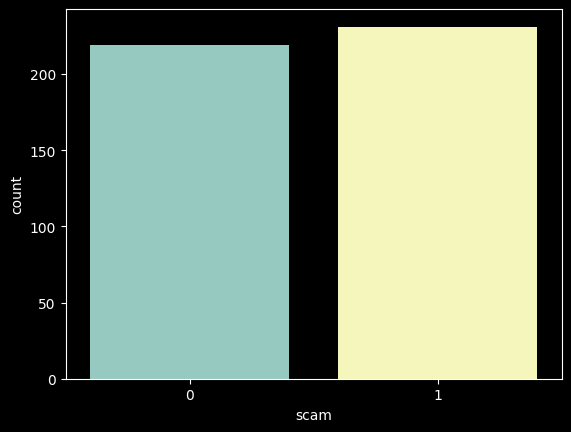

In [53]:
sns.countplot(x=df_OD["scam"])

In [54]:
from sklearn.preprocessing import LabelEncoder
lb_enc = LabelEncoder()
y = lb_enc.fit_transform(df_OD["scam"])

In [55]:
tokenizer = Tokenizer() #initializing the tokenizer
tokenizer.fit_on_texts(X)# fitting on the sms data
text_to_sequence = tokenizer.texts_to_sequences(X)
print(X)

0      changing world creates publishes content even ...
1      hello worldtalents drive change digital recrui...
2      summaryresponsible acting liaison customer com...
3      addition clerical administrative duty individu...
4      looking career challenge allow make impact eve...
                             ...                        
445    prepares source data computer entry compiling ...
446    job descriptionvertex global solution seek exe...
447    apply using linkurlabecbbbaadffccccaaebor spec...
448    sarbari highgrowth investmentbacked software c...
449    healthlink provides computer communication sys...
Name: text, Length: 450, dtype: object


In [56]:
max_length_sequence = max([len(i) for i in text_to_sequence])
 # finding the length of largest sequence
padded_sms_sequence = pad_sequences(text_to_sequence, maxlen=max_length_sequence, 
                                    padding = "pre") 
len(padded_sms_sequence)

450

In [57]:
TOT_SIZE = len(tokenizer.word_index)+1
def create_model():
      lstm_model = Sequential()
      lstm_model.add(Embedding(TOT_SIZE, 32, input_length=max_length_sequence))
      lstm_model.add(LSTM(50))
      lstm_model.add(Dropout(0.4))
      lstm_model.add(Dense(20, activation="relu"))
      lstm_model.add(Dropout(0.3))
      lstm_model.add(Dense(1, activation = "sigmoid"))
      return lstm_model
lstm_model = create_model()
lstm_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["binary_crossentropy"])
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 2700, 32)          421536    
                                                                 
 lstm_2 (LSTM)               (None, 50)                16600     
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 20)                1020      
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 439177 (1.68 MB)
Trainable params: 43917

In [65]:
history=lstm_model.fit(padded_sms_sequence, y, epochs =11, validation_split=0.2, batch_size=64)

Epoch 1/11
6/6 [==============================] - 5s 895ms/step - loss: 0.2617 - binary_crossentropy: 0.2617 - val_loss: 0.5136 - val_binary_crossentropy: 0.5136
Epoch 2/11
6/6 [==============================] - 5s 916ms/step - loss: 0.2145 - binary_crossentropy: 0.2145 - val_loss: 0.4507 - val_binary_crossentropy: 0.4507
Epoch 3/11
6/6 [==============================] - 5s 914ms/step - loss: 0.1651 - binary_crossentropy: 0.1651 - val_loss: 0.3794 - val_binary_crossentropy: 0.3794
Epoch 4/11
6/6 [==============================] - 5s 897ms/step - loss: 0.1178 - binary_crossentropy: 0.1178 - val_loss: 0.3012 - val_binary_crossentropy: 0.3012
Epoch 5/11
6/6 [==============================] - 5s 904ms/step - loss: 0.0716 - binary_crossentropy: 0.0716 - val_loss: 0.3155 - val_binary_crossentropy: 0.3155
Epoch 6/11


KeyboardInterrupt: 

In [148]:
df_test = df_test.fillna("")
df_test['description']=df_test['company_profile']+df_test['description']
df_OD_test = df_test[['fraudulent', 'description']].copy()
df_OD_test.head()
df_OD_test['scam'] = df_test['fraudulent'].map(lambda x:fraudulent(x))
df_OD_test['text']= df_test['description'].copy()
df_OD_test=df_OD_test.drop(['fraudulent', 'description'], axis=1)
df_OD_test['text']=df_OD_test['text'].apply(lambda cw : remove_tags(cw))
X = df_OD_test["text"].apply(preprocessing)
for i in range(5):
           print("Text               : ",X[i] )
           print("Numerical Sequence : ", text_to_sequence[i])
tokenizer = Tokenizer() #initializing the tokenizer
tokenizer.fit_on_texts(X)# fitting on the sms data
text_to_sequence = tokenizer.texts_to_sequences(X)

 # finding the length of largest sequence
padded_sms_sequence_test = pad_sequences(text_to_sequence, maxlen=max_length_sequence, 
                                    padding = "pre") 
padded_sms_sequence_test


Text               :  accepting online application onlyclick applythis full time temporary position lasting yearsdescriptionvalidate review legal contractual agreement customer input contract contract database contract completed amp reviewed within perdetermined service level agreement professional email interaction customer scanning uploading documentsqualificationshigh school diploma equivalent professional communication skill via email interactiondedicated need business project management skill assist facilitating multiple contract reject detail oriented able multitaskability work time sensitive document must able work independently able perform team environment needed fast accurate typistaccepting online application onlyclick apply
Numerical Sequence :  [1204, 64, 46, 697, 1285, 67, 14, 489, 16, 958, 1286, 390, 1056, 1205, 658, 5, 698, 144, 144, 414, 144, 1057, 9, 1206, 84, 1287, 2, 73, 658, 28, 158, 472, 5, 959, 1207, 1288, 296, 1058, 1059, 28, 50, 17, 275, 158, 1289, 23, 6, 22, 1

array([[   0,    0,    0, ...,   49,  847,  135],
       [   0,    0,    0, ...,   21,  313, 1309],
       [   0,    0,    0, ..., 1173, 1174, 1175],
       ...,
       [   0,    0,    0, ...,  829,  895, 1539],
       [   0,    0,    0, ...,  834,   15,   28],
       [   0,    0,    0, ...,    3,  377, 1008]], dtype=int32)

In [67]:
lb_enc = LabelEncoder()
y_test = lb_enc.fit_transform(df_OD_test["scam"])

In [68]:
len(padded_sms_sequence_test)

450

In [132]:
pred = lstm_model.predict(padded_sms_sequence_test)
y_pred=[]
med= np.median(pred)
print(med)
for i in range(0,pred.size):
    if pred[i][0] >med:
        y_pred.append(1)
    else:
        y_pred.append(0)
from sklearn.metrics import confusion_matrix


confusion_matrix(y_test, y_pred)

15/15 [==============================] - 3s 189ms/step
0.45536363


array([[173,  58],
       [ 53, 166]])

In [133]:
hist,bins = np.histogram(pred,bins = [0,0.2,0.4,0.6,0.8,1]) 

In [134]:
hist

array([209,  12,   6,  43, 180])

In [135]:
import pickle
pickle.dump(lstm_model, open('model2.pkl', 'wb'))

In [136]:
model = pickle.load(open('model2.pkl','rb'))
pred = model.predict(padded_sms_sequence_test)

y_pred=[]
y_column=[]
med= np.median(pred)
print(med)
for i in range(0,pred.size):
    if pred[i][0] >med:
        y_pred.append(1)
    else:
        y_pred.append(0)
    y_column.append(pred[i][0])
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

15/15 [==============================] - 2s 136ms/step
0.45536363


array([[173,  58],
       [ 53, 166]])

In [149]:
df_test['LSTM_PREDICT'] = y_pred

In [150]:
df_test

,Unnamed: 0,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset,LSTM_PREDICT
0,5,Data Entry Admin/Clerical Positions - Work Fro...,"US, AK, Anchorage",,,,<p>ACCEPTING ONLINE APPLICATIONS ONLY</p>\r\n<...,,,f,f,f,,,,,,t,t,1
1,7,administrative assistance,"US, NY, Moravia",admin,13-20,,<p>This position is for an Administrative Assi...,<ul>\r\n<li>Must be proficient with Outlook</l...,<p>Benefit includes: health and welfare covera...,f,f,f,Other,Entry level,High School or equivalent,Accounting,Administrative,t,t,1
2,8,Cruise Staff Wanted *URGENT*,"US, NY, MANHATTAN",,,,<p><b>6* Ultra Luxury American Cruise Company ...,<p><b>Certification &amp; Experience:</b>ÃÂÃ...,<p><b>Benefits:</b>ÃÂÃÂ On board en suite a...,f,f,f,Full-time,,,"Leisure, Travel & Tourism",,t,t,0
3,9,KMC,,,,,<p>This is for the KMC project.</p>\r\n<p></p>...,,,f,f,f,,,,,,t,t,1
4,10,Assistant Account position!!!,"AU, ,",,,,<p>An exciting opportunity exists to fill a pa...,<p>To be considered for this role you will hav...,<ul>\r\n<li>good salary</li>\r\n</ul>,f,f,t,Part-time,,,,,t,t,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,892,Military Benefits Counselor,"US, , chicago",HR,,<p>Anthony Warren is a Marketing and Advertisi...,<p>Anthony Warren is a Marketing and Advertisi...,<p>must be:</p>\r\n<p>Active duty or veteran s...,,t,t,t,,,,,,t,t,1
446,894,Customer Service/Accounting Clerk,"US, MI, DETROIT",Account/finance,,,<p>Cigna Inc is a prolific company seeking a s...,"<p>Attention to Detail, Confidentiality, Thoro...",,f,f,f,Full-time,Entry level,High School or equivalent,Hospital & Health Care,Accounting/Auditing,t,t,0
447,895,Student Positions Part-Time and Full-Time.,"US, CA, Los Angeles",,,,<p>Student Positions Part-Time and Full-Time.<...,,,f,f,f,Part-time,,,,,t,t,1
448,897,Android Developer,"PL, MZ, Warsaw",,,,<p>inFullMobile Sp. z o.o. is a mobile softwar...,<p>ÃÂ¢ÃÂÃÂ¢ A proven track record in Andro...,<ul>\r\n<li>attractive salary (adequate to the...,f,f,f,,,,,,t,t,1


In [151]:
df_test.to_csv('EDA_Dataset.csv',index=False)

In [4]:
df_works=pd.read_csv('EDA_Dataset.csv')

In [5]:
df_fraudulent=df_works[df_works['fraudulent']=='f']

<Axes: xlabel='LSTM_PREDICT', ylabel='count'>

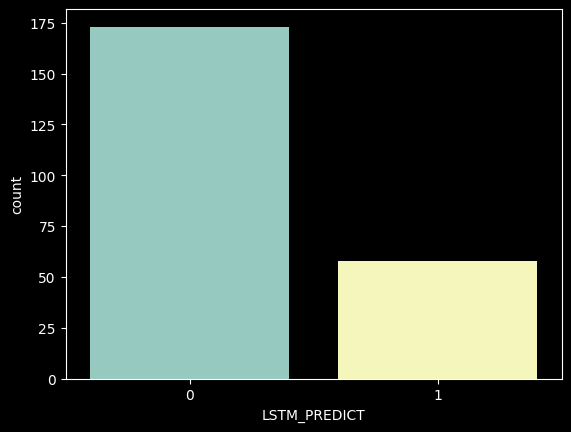

In [6]:
sns.countplot(df_fraudulent, x="LSTM_PREDICT")

In [10]:
df_true=df_works[df_works['fraudulent']=='t']

In [11]:
sum(df_true['LSTM_PREDICT'])/len(df_true['LSTM_PREDICT'])

0.7579908675799086